In [1]:
########################################
# Packages
########################################
import warnings
import h5py as h5
import numpy as np
import pandas as pd
import multiprocessing as mp

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import math

import statistics

from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic
import scipy.stats.distributions as dist

import seaborn as sns

In [2]:
from data_processing import SHARKDataProcessor
processor = SHARKDataProcessor()

# Define subvolume IDs and HDF5 file paths
sv_list = np.arange(64)
sharkfiles = [f'extracted_data_z=0/199/{sv}/galaxies.hdf5' for sv in sv_list] #DEFINE FILE

# Output shark_csv dataframe
shark_csv = processor.process_all_subvolumes(sv_list, sharkfiles)
print(shark_csv.head())

  ID_galaxy ID_subhalo    ID_subhalo_tree ID_halo  sv  type    Mhalo_host  \
0   0_12323        0_1  0_199000000000184     0_1   0     0  1.553645e+12   
1   0_41884        0_2  0_199000000032613     0_1   0     1  1.553645e+12   
2   0_25337        0_4  0_199000000000239     0_2   0     0  1.013176e+12   
3   0_12324        0_4  0_199000000000239     0_2   0     2  1.013176e+12   
4  0_325815        0_5  0_199000000032723     0_2   0     1  1.013176e+12   

          Mhalo   Mstar_bulge    Mstar_disc  ...  SFR_bulge  SFR_disc  \
0  1.406334e+12  4.406725e+10  8.090279e+09  ...   0.239161  8.448190   
1  1.132662e+11  6.663850e+07  3.927870e+08  ...   0.000000  0.045958   
2  7.889350e+11  1.441911e+10  7.342129e+06  ...   5.469577  0.054259   
3  4.321138e+10  4.237961e+08  9.966004e+08  ...   0.000000  0.128186   
4  2.242409e+11  4.860634e+08  7.437644e+08  ...   0.000000  0.316807   

    SFR_all           MBH  MBHacc_cold    MBHacc_hot    MBHacc_all  \
0  8.687351  2.992633e+07   

In [3]:
########################################
# gal_sv settings
########################################
# type: galaxy type; =0 for centrals; =1 for satellites that reside in well identified subhalos; =2 for orphan satellites

shark_csv_centrals = shark_csv[(shark_csv['type'] == 0)] ######## Centrals only
shark_csv_satellites = shark_csv[(shark_csv['type'] == 1)] ######## Satellites only
shark_csv_satANDor = shark_csv[(shark_csv['type'].isin([1, 2]))] ######## Satellites and Orphans

In [4]:
# Copy dataframe values that I want
dexframe = shark_csv[['ID_galaxy', 'type', 'Mhalo_host', 'Mstar_all', 
                              'Mhotgas', 'Mcoldgas_bulge', 'Mcoldgas_disc', 'Mcoldgas_all', 
                              'SFR_bulge', 'SFR_disc', 'SFR_all']].copy()

print(dexframe.head())
print(dexframe.shape)

  ID_galaxy  type    Mhalo_host     Mstar_all       Mhotgas  Mcoldgas_bulge  \
0   0_12323     0  1.553645e+12  5.215753e+10  1.975498e+11    4.745630e+08   
1   0_41884     1  1.553645e+12  4.594255e+08  1.106057e+10    0.000000e+00   
2   0_25337     0  1.013176e+12  1.442645e+10  1.221569e+11    2.857738e+09   
3   0_12324     2  1.013176e+12  1.420396e+09  0.000000e+00    0.000000e+00   
4  0_325815     1  1.013176e+12  1.229828e+09  2.579047e+10    0.000000e+00   

   Mcoldgas_disc  Mcoldgas_all  SFR_bulge  SFR_disc   SFR_all  
0   2.537169e+10  2.584625e+10   0.239161  8.448190  8.687351  
1   4.259521e+08  4.259521e+08   0.000000  0.045958  0.045958  
2   5.663756e+09  8.521494e+09   5.469577  0.054259  5.523837  
3   4.992609e+08  4.992609e+08   0.000000  0.128186  0.128186  
4   6.025936e+08  6.025936e+08   0.000000  0.316807  0.316807  
(928625, 11)


In [5]:
# Compute SHMR for centrals and binned (16 bins) medians
SHMR_threshold = 10**-4
SHMR_centrals = shark_csv_centrals['Mstar_all'] / shark_csv_centrals['Mhalo_host']
SHMR_centrals = np.where(SHMR_centrals < SHMR_threshold, SHMR_threshold, SHMR_centrals)

# Create log bins for Mhalo_host
lowLog = round(math.log10(shark_csv_centrals['Mhalo_host'].min()), 0)
highLog = round(math.log10(shark_csv_centrals['Mhalo_host'].max()), 0)
num_bins = 16
logBins = np.logspace(lowLog, highLog, num=num_bins + 1)

# Compute median SHMR for centrals in each bin
result = binned_statistic(
    shark_csv_centrals['Mhalo_host'],
    SHMR_centrals,
    statistic='median',
    bins=logBins
)

# Extract bin medians
bin_medians = result.statistic  # 15 median values for 16 bins

# Print median SHMR values
print("Median SHMR values for centrals in each bin:")
print(bin_medians)

Median SHMR values for centrals in each bin:
[0.01013983 0.0053878  0.0021602  0.00285382 0.00578228 0.0141957
 0.02694881 0.01515239 0.01142444 0.00951415 0.00859169 0.00746539
 0.00663614 0.00579824 0.0046551  0.00336142]


In [6]:
# Calculate residual wrt binned median SHMR values for centrals
SHMR_threshold_univ = 10**-4
SHMR_univ = dexframe['Mstar_all'] / dexframe['Mhalo_host'] 
SHMR_univ = np.where(SHMR_univ < SHMR_threshold_univ, SHMR_threshold_univ, SHMR_univ)

residuals = []

for j in range(len(logBins) - 1):
    if j == len(logBins) - 2:  # Last bin
        bin_indices = (dexframe['Mhalo_host'] >= logBins[j]) & (dexframe['Mhalo_host'] <= logBins[j + 1])  # Include upper edge
    else:
        bin_indices = (dexframe['Mhalo_host'] >= logBins[j]) & (dexframe['Mhalo_host'] < logBins[j + 1])
    
    bin_data = SHMR_univ[bin_indices]  # extract values corresponding to Mhalo_host values within the current bin
        
    if len(bin_data) > 0:  # Will not calculate residual of empty bins
        current_residuals = np.log10(bin_data) - np.log10(bin_medians[j]) # measurable variable - approximate variable
            
        # Replace zeros with a small value to avoid log10(0)
        current_residuals[current_residuals == 0] = 1e-10
            
        residuals.extend(current_residuals)
    else:
        print("bin error: empty bin")

# Convert residuals to numpy array
residuals = np.array(residuals)
x_residuals = dexframe['Mhalo_host'][dexframe['Mhalo_host'] >= logBins[0]]
print(f"x_residuals shape: {x_residuals.shape}, residuals shape: {residuals.shape}")

x_residuals shape: (925871,), residuals shape: (925871,)


In [7]:
import numpy as np

# Compute SHMR for all galaxies
SHMR_threshold_univ = 10**-4
SHMR_univ = dexframe['Mstar_all'] / dexframe['Mhalo_host']
SHMR_univ = np.where(SHMR_univ < SHMR_threshold_univ, SHMR_threshold_univ, SHMR_univ)

# Initialize residuals array with NaNs (same shape as dexframe)
residuals = np.full(len(dexframe), np.nan)

# Loop through bins and calculate residuals
for j in range(len(logBins) - 1):
    if j == len(logBins) - 2:  # Last bin
        bin_indices = (dexframe['Mhalo_host'] >= logBins[j]) & (dexframe['Mhalo_host'] <= logBins[j + 1])  # Include upper edge
    else:
        bin_indices = (dexframe['Mhalo_host'] >= logBins[j]) & (dexframe['Mhalo_host'] < logBins[j + 1])
    
    bin_data = SHMR_univ[bin_indices]  # extract values corresponding to Mhalo_host values within the current bin
        
    if len(bin_data) > 0:  # Will not calculate residual of empty bins
        residuals[bin_indices] = np.log10(bin_data) - np.log10(bin_medians[j])
    else:
        print(f"  - Empty Bin {j+1}: No residuals assigned.")

# Add residuals to dexframe
dexframe['dex_residual_wrt_centrals'] = residuals

# Identify and remove galaxies with missing residuals (NaN values)
missing_residuals = dexframe[dexframe['dex_residual_wrt_centrals'].isna()]
print(f"\nRemoving {len(missing_residuals)} galaxies with missing residuals.")

dexframe = dexframe.dropna(subset=['dex_residual_wrt_centrals']).reset_index(drop=True)

# Final shape check
print(f"Updated dexframe shape: {dexframe.shape}")



Removing 2754 galaxies with missing residuals.
Updated dexframe shape: (925871, 12)


In [8]:
dexframe.head

<bound method NDFrame.head of         ID_galaxy  type    Mhalo_host     Mstar_all       Mhotgas  \
0         0_12323     0  1.553645e+12  5.215753e+10  1.975498e+11   
1         0_41884     1  1.553645e+12  4.594255e+08  1.106057e+10   
2         0_25337     0  1.013176e+12  1.442645e+10  1.221569e+11   
3         0_12324     2  1.013176e+12  1.420396e+09  0.000000e+00   
4        0_325815     1  1.013176e+12  1.229828e+09  2.579047e+10   
...           ...   ...           ...           ...           ...   
925866   63_43237     1  3.466862e+13  9.083127e+08  0.000000e+00   
925867   63_45659     0  2.291512e+10  1.053442e+08  8.837895e+08   
925868   63_34542     0  2.023078e+11  1.237175e+09  1.740958e+10   
925869   63_61565     0  6.678122e+10  1.587325e+08  4.474078e+09   
925870  63_121398     0  1.283247e+11  3.374586e+08  6.412826e+09   

        Mcoldgas_bulge  Mcoldgas_disc  Mcoldgas_all  SFR_bulge  SFR_disc  \
0         4.745630e+08   2.537169e+10  2.584625e+10   0.239161  8

len negative residuals 120128
len positive residuals 2485
residual=0 0


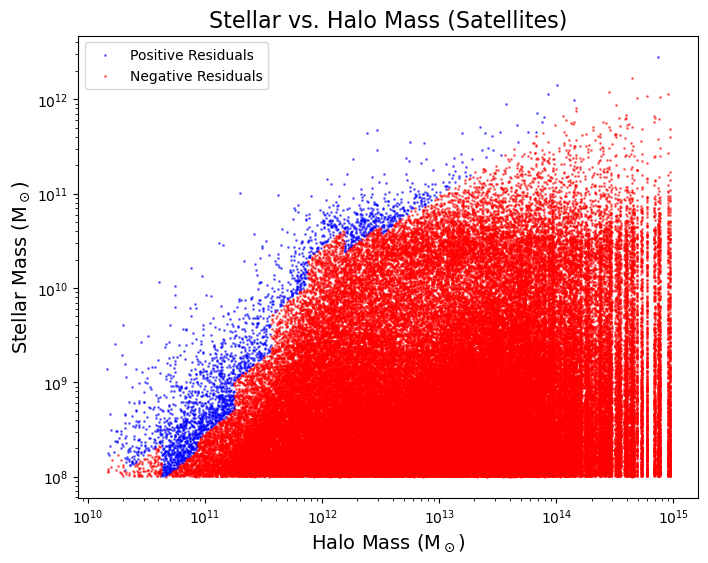

In [9]:
import matplotlib.pyplot as plt

# Filter for satellites
satellites = dexframe[dexframe['type'] == 1]

# Separate galaxies based on residual sign
pos_residuals = satellites[satellites['dex_residual_wrt_centrals'] > 0]
neg_residuals = satellites[satellites['dex_residual_wrt_centrals'] < 0]
int_residuals = satellites[satellites['dex_residual_wrt_centrals'] == 0]

print('len negative residuals', len(neg_residuals))
print('len positive residuals',len(pos_residuals))
print('residual=0', len(int_residuals))

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(pos_residuals['Mhalo_host'], pos_residuals['Mstar_all'], 
           color='blue', s=1, alpha=0.5, label="Positive Residuals")

ax.scatter(neg_residuals['Mhalo_host'], neg_residuals['Mstar_all'], 
           color='red', s=1, alpha=0.5, label="Negative Residuals")

# Log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Labels & Title
ax.set_xlabel(r'Halo Mass (M$_\odot$)', fontsize=14)
ax.set_ylabel(r'Stellar Mass (M$_\odot$)', fontsize=14)
ax.set_title("Stellar vs. Halo Mass (Satellites)", fontsize=16)

# Legend
ax.legend()

plt.show()


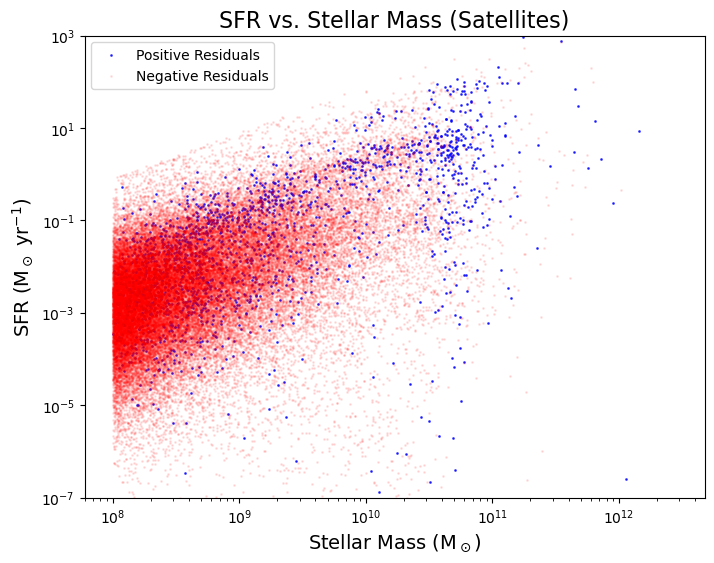

In [10]:
import matplotlib.pyplot as plt

# Filter for satellites
satellites = dexframe[dexframe['type'] == 1]

# Separate galaxies based on residual sign
pos_residuals = satellites[satellites['dex_residual_wrt_centrals'] > 0]
neg_residuals = satellites[satellites['dex_residual_wrt_centrals'] < 0]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(pos_residuals['Mstar_all'], pos_residuals['SFR_all'], 
           color='blue', s=1, alpha=0.7, label="Positive Residuals")

ax.scatter(neg_residuals['Mstar_all'], neg_residuals['SFR_all'], 
           color='red', s=1, alpha=0.1, label="Negative Residuals")

# Log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Labels & Title
ax.set_xlabel(r'Stellar Mass (M$_\odot$)', fontsize=14)
ax.set_ylabel(r'SFR (M$_\odot$ yr$^{-1}$)', fontsize=14)
ax.set_title("SFR vs. Stellar Mass (Satellites)", fontsize=16)
ax.set_ylim(1e-7, 1e3)

# Legend
ax.legend()

plt.show()


Removing 103731 galaxies with SFR_all = 0


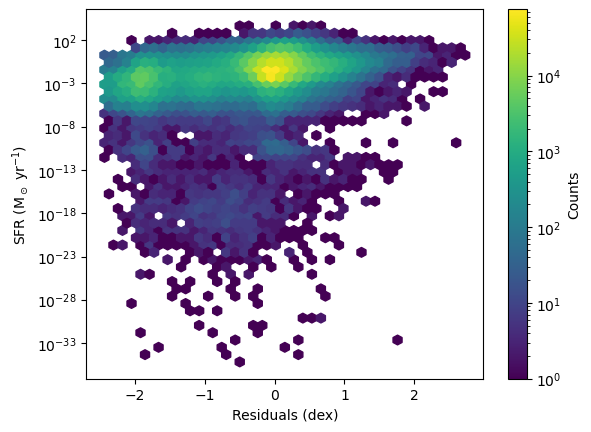

In [11]:
num_zeros = (dexframe['SFR_all'] == 0).sum()
print(f"Removing {num_zeros} galaxies with SFR_all = 0")

# nonzero_dexframe has no SFR = 0. 
nonzero_dexframe = dexframe[dexframe['SFR_all'] > 0]

plt.hexbin(nonzero_dexframe['dex_residual_wrt_centrals'], nonzero_dexframe['SFR_all'],
           gridsize=40,
           bins='log',
           yscale='log'
          )
plt.colorbar(label='Counts')
plt.xlabel('Residuals (dex)')
plt.ylabel(r'SFR (M$_\odot$ yr$^{-1}$)')
plt.show()

Removing 45536 galaxies with Mcoldgas_all = 0


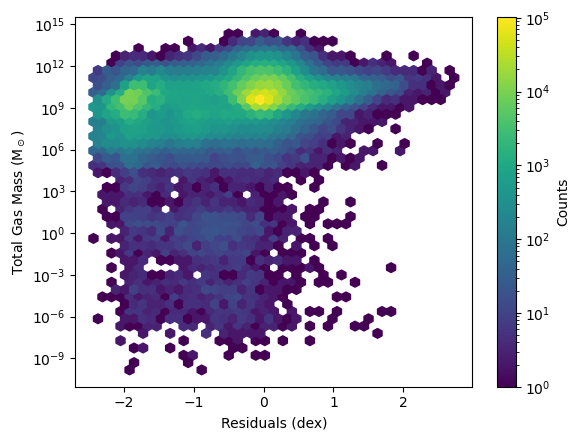

In [34]:
#Create a new field
dexframe['Mtotal_gas'] = dexframe['Mcoldgas_all'] + dexframe['Mhotgas']

num_zeros = (dexframe['Mtotal_gas'] == 0).sum()
print(f"Removing {num_zeros} galaxies with Mcoldgas_all = 0")

# nonzero_dexframe has no Mcoldgas_all = 0. 
nonzero_dexframe2 = dexframe[dexframe['Mtotal_gas'] > 0]

plt.hexbin(nonzero_dexframe2['dex_residual_wrt_centrals'], nonzero_dexframe2['Mtotal_gas'],
           gridsize=40,
           bins='log',
           yscale='log'
          )
plt.colorbar(label='Counts')
plt.xlabel('Residuals (dex)')
plt.ylabel(r'Total Gas Mass (M$_\odot$)')

plt.show()

Removing 104871 galaxies with Mcoldgas_all = 0


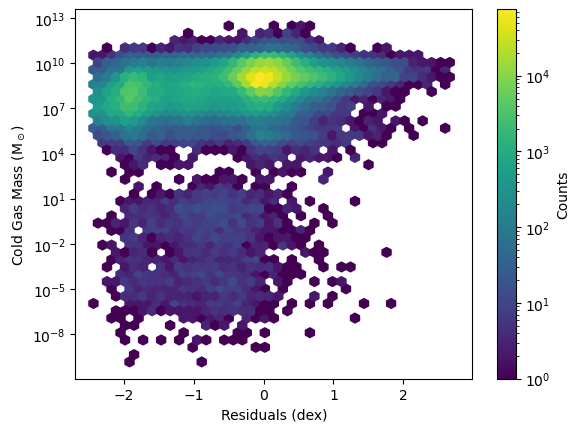

In [36]:
num_zeros = (dexframe['Mcoldgas_all'] == 0).sum()
print(f"Removing {num_zeros} galaxies with Mcoldgas_all = 0")

# nonzero_dexframe has no Mcoldgas_all = 0. 
nonzero_dexframe2 = dexframe[dexframe['Mcoldgas_all'] > 0]

plt.hexbin(nonzero_dexframe2['dex_residual_wrt_centrals'], nonzero_dexframe2['Mcoldgas_all'],
           gridsize=40,
           bins='log',
           yscale='log'
          )
plt.colorbar(label='Counts')
plt.xlabel('Residuals (dex)')
plt.ylabel(r'Cold Gas Mass (M$_\odot$)')

plt.show()

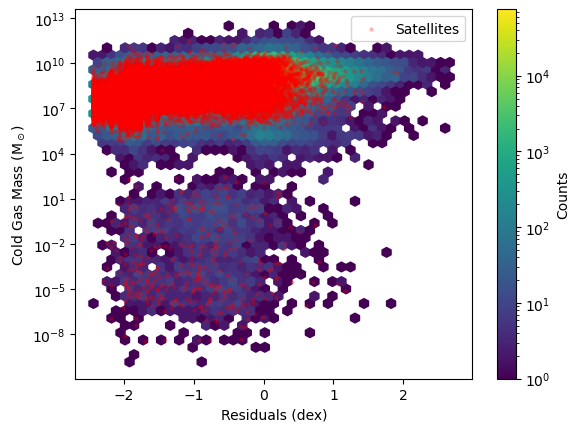

In [13]:
# Filter out satellites and nonzero cold gas
satellites = nonzero_dexframe2[nonzero_dexframe2['type'] == 1]

# Hexbin Plot
plt.hexbin(nonzero_dexframe2['dex_residual_wrt_centrals'], nonzero_dexframe2['Mcoldgas_all'],
           gridsize=40,
           bins='log',
           yscale='log',
           cmap='viridis'
          )
plt.colorbar(label='Counts')
plt.xlabel('Residuals (dex)')
plt.ylabel(r'Cold Gas Mass (M$_\odot$)')

# Overlay Scatter Plot for Satellites
plt.scatter(satellites['dex_residual_wrt_centrals'], satellites['Mcoldgas_all'],
            color='red', s=5, alpha=0.2, label='Satellites')  # Small red circles, alpha=0.3

# Add Legend
plt.legend()

plt.show()


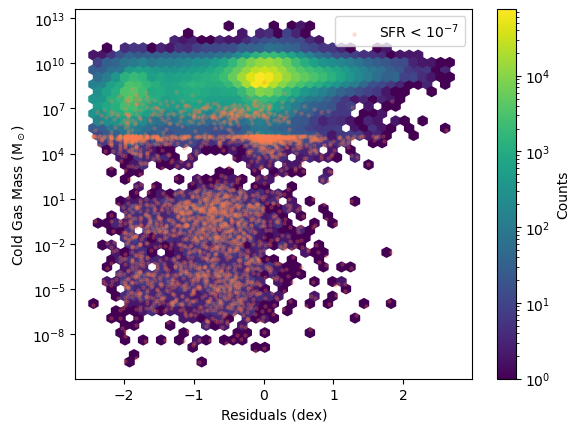

In [30]:
# Filter all galaxies with SFR < 10^-7
low_sfr = nonzero_dexframe2[nonzero_dexframe2['SFR_all'] < 1e-7]

# Hexbin Plot
plt.hexbin(nonzero_dexframe2['dex_residual_wrt_centrals'], nonzero_dexframe2['Mcoldgas_all'],
           gridsize=40,
           bins='log',
           yscale='log',
           cmap='viridis'
          )
plt.colorbar(label='Counts')
plt.xlabel('Residuals (dex)')
plt.ylabel(r'Cold Gas Mass (M$_\odot$)')

# Overlay Scatter Plot for Low SFR Galaxies (White Dots)
plt.scatter(low_sfr['dex_residual_wrt_centrals'], low_sfr['Mcoldgas_all'],
            color='coral', s=5, alpha=0.2, label='SFR < $10^{-7}$')

# Add Legend
plt.legend()

plt.show()
